In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import matrix_rank
import datetime
import math
#specify that all columns should be shown
pd.set_option('display.max_columns', None)

## Read data frames

In [53]:
path_to_preprocessed = 'Data/Schöpfleuthnergasse/Preprocessed data/' #write path to the you own folder

### This is preprocessed Aufmasblatt file

In [54]:
AMBL_df = pd.read_csv(path_to_preprocessed + 'AMBL.csv')
AMBL_df.head(3)

,kurztext,ergebnis,me,le,le_datum,bz,comment,factor,blatt,zeile,revitid,dt
0,Mulden,1042.0,VE,1,2021-03-01,1,NaN,NaN,1.0,100.0,0,2021-03-01
1,Mulden,408.0,VE,1,2021-04-01,2,NaN,NaN,1.0,1700.0,0,2021-04-01
2,Mulden,1121.0,VE,1,2021-05-01,3,NaN,NaN,1.0,2900.0,0,2021-05-01


In [55]:
KST_df = pd.read_csv(path_to_preprocessed + 'KST.csv')
KST_df.head(6)

,konto,text,belegnummer,kr_db,betrag,menge,me,date
0,11100,LÖHNE,0003LL,NaN,6554.26,0.0,NaN,2021-03-01
1,11100,LÖHNE,0003LL,NaN,335.91,0.0,NaN,2021-03-01
2,11100,LÖHNE,0004LL,NaN,11007.66,0.0,NaN,2021-04-01
3,11100,LÖHNE,0004LL,NaN,638.18,0.0,NaN,2021-04-01
4,11100,LÖHNE,0005LL,NaN,12048.99,0.0,NaN,2021-05-01
5,11100,LÖHNE,0005LL,NaN,715.36,0.0,NaN,2021-05-01


### This is preprocessed export file of BIM model

In [56]:
BIM_model_df = pd.read_csv(path_to_preprocessed + 'BIMmodel.csv')
BIM_model_df.head(3)

,name,class,objectid,elementid,5d Bauteil,5d Geschoss,5d Los,Volumen,Fläche,Breite,Dicke,Länge,cpiComponentType,Material
0,"5dsf-IW-Freist. Vorsatzschale CW75 1GKPl. 12,5...",5D-AB-IW-MSTW-VS,00140115-8783-41e8-99e6-7a372dcf523d-00340f03,3411715,NaN,OG05,W05,0.771,8.817,0.088,NaN,3.426,Wall,5dsf-IW-CW-VS
1,"5dsf-IW-ESTW-CW75/100mm 42dB 2GKPl. 12,5mm - IW07",5D-AB-IW-MSTW,00140115-8783-41e8-99e6-7a372dcf523d-00340f04,3411716,NaN,OG05,W05,0.240,2.399,0.100,NaN,0.882,Wall,5dsf-IW-CW-ESTW
2,5dsf-IW-ESTW-CW75/1125mm 49dB 3xGKPl. IW14,5D-AB-IW-MSTW,00140115-8783-41e8-99e6-7a372dcf523d-00340f05,3411717,NaN,OG05,W05,0.368,3.269,0.113,NaN,1.260,Wall,NaN


### Prepare data for merging

In [57]:
AMBL_df_no_empty_revitid = AMBL_df.loc[AMBL_df.revitid != 0]
BIM_model_df = BIM_model_df.loc[BIM_model_df.elementid != 0]

In [58]:
AMBL_to_be_merged = AMBL_df_no_empty_revitid \
                                        .groupby(['revitid', 'dt'], as_index = False) \
                                                .agg({'ergebnis':'sum'}) 


In [59]:
BIM_to_be_merged = BIM_model_df.rename(columns = {'elementid':'revitid',
                                                '5d Bauteil':'5d_bauteil',
                                                '5d Geschoss':'5d_geschoss',
                                                '5d Los':'5d_los',
                                                'cpiComponentType':'cpi_component_type',
                                                'Volumen':'volume',
                                                'Fläche':'area',
                                                'Breite':'width',
                                                'Dicke':'thick',
                                                'Länge':'length',
                                                'Material':'material'})

In [60]:
merged_df = BIM_to_be_merged.merge(AMBL_to_be_merged, how='inner', on='revitid')

In [61]:
class_list = merged_df['class'].unique()
month_list = sorted(merged_df['dt'].unique())
print(class_list)
print(month_list)

['5D-AB-IW-MSTW-VS' '5D-AB-IW-MSTW' '5D-AB-WVK-WK' '5D-KI-DE'
 '5D-KI-STB-W' '5D-KI-STB-W-E' '5D-KI-TR-UZ' '5D-KI-BoPla' '5D-KI-DE-E'
 '5D-KI-SD' '5D-KI-BODENSCHLITZ' '5D-KI-EBT-VR' '5D-KI-TRE-FT'
 '5D-KI-DE-BALKON' '5D-KI-RAMPE' '5D-AB-WVK-WK-DS' '5D-KI-TRE-FTPOD'
 '5D-KI-FT-BRP' '5D-KI-STB-ISOKORB' '5D-KI-FU-AUB' '5D-KI-FU-AUW'
 '5D-KI-FT-WAP' '5D-KI-FT-SONNENSCHUTZ' '5D-KI-STB-W-BAPS' '5D-KI-SKS'
 '5D-KI-EW-PFT' '5D-KI-ST-REC' '5D-KI-STB-W-1S']
['2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-08-01']


In [62]:
A_df = merged_df \
                        .groupby(['class','dt'], as_index = False) \
                            .agg({'volume':'sum'})

### Let's look at the amount of the classes

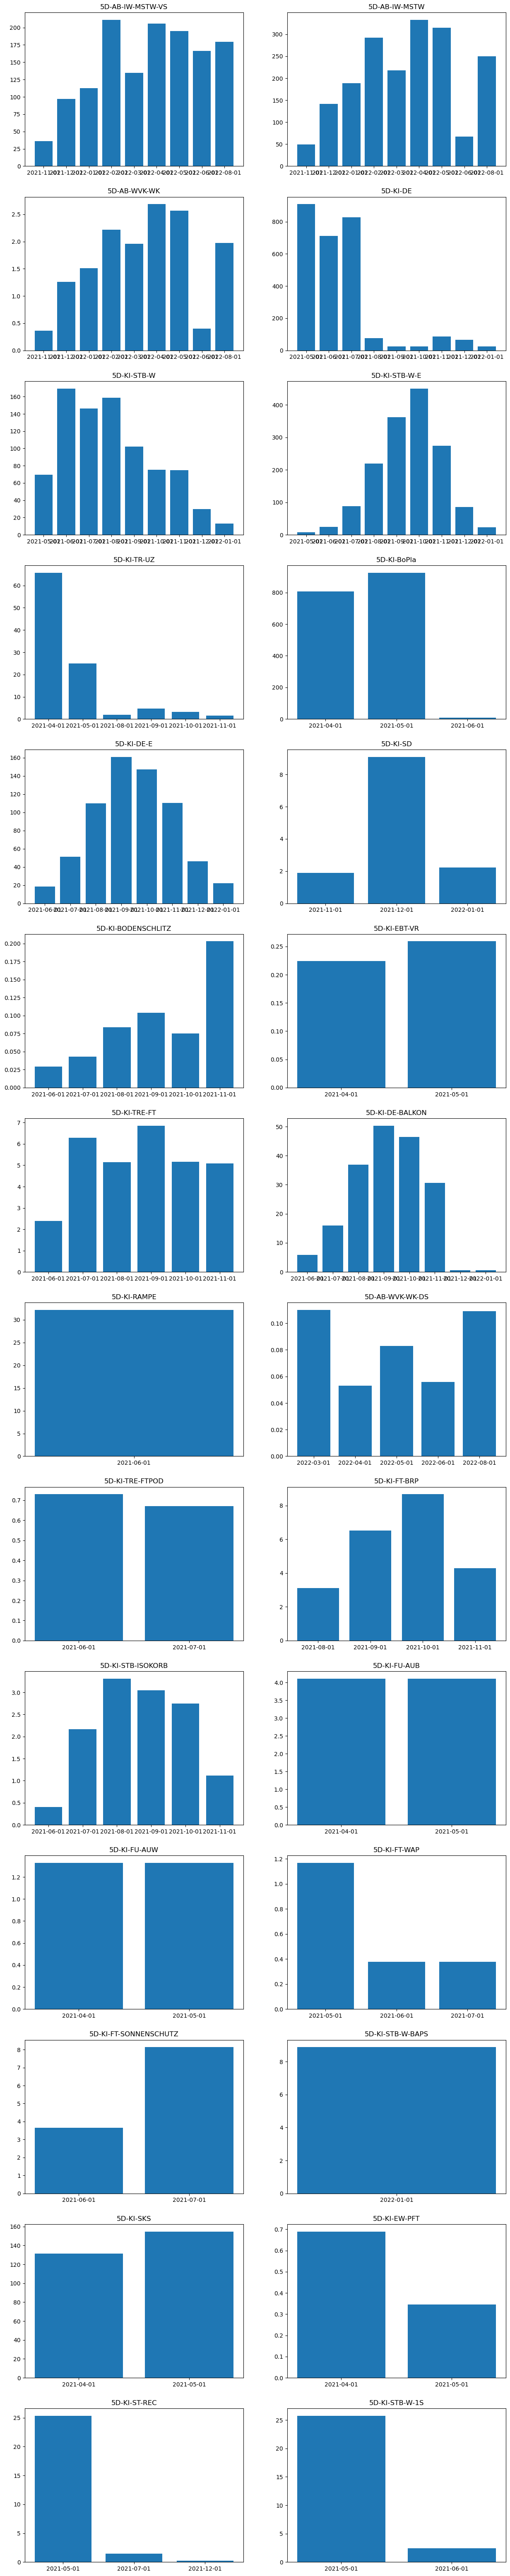

In [63]:
#define grid of plots
fig, axs = plt.subplots(len(class_list)//2, 2, figsize=(15, 80))
i = 0
for cll in class_list:
    xx = A_df.loc[A_df['class'] == cll].dt
    yy = A_df.loc[A_df['class'] == cll].volume
    axs[i//2][i%2].set_title(cll)
    axs[i//2][i%2].bar(xx ,yy)
    i = i + 1


### Prepare data for SLE based on classes

In [64]:
### make matrix A
def create_A(df):
    n = len(month_list) #number of rows = number of months of the project
    m = len(class_list) #number of columns = number of unique elemints in te project(based on kurztext)
    A = np.zeros((n, m), dtype=float)
    k = 0
    for month in month_list:
        l = 0
        for clss in class_list:
            tmp = df.loc[(df['dt'] == month) & (df['class'] == clss)]
            if tmp.shape[0]==1:
                A[k][l] = tmp.volume
            l = l + 1
        k = k + 1
    return A, class_list, month_list
            
        

In [65]:
A, mnth, clss = create_A(A_df)

In [66]:
mnth

array(['5D-AB-IW-MSTW-VS', '5D-AB-IW-MSTW', '5D-AB-WVK-WK', '5D-KI-DE',
       '5D-KI-STB-W', '5D-KI-STB-W-E', '5D-KI-TR-UZ', '5D-KI-BoPla',
       '5D-KI-DE-E', '5D-KI-SD', '5D-KI-BODENSCHLITZ', '5D-KI-EBT-VR',
       '5D-KI-TRE-FT', '5D-KI-DE-BALKON', '5D-KI-RAMPE',
       '5D-AB-WVK-WK-DS', '5D-KI-TRE-FTPOD', '5D-KI-FT-BRP',
       '5D-KI-STB-ISOKORB', '5D-KI-FU-AUB', '5D-KI-FU-AUW',
       '5D-KI-FT-WAP', '5D-KI-FT-SONNENSCHUTZ', '5D-KI-STB-W-BAPS',
       '5D-KI-SKS', '5D-KI-EW-PFT', '5D-KI-ST-REC', '5D-KI-STB-W-1S'],
      dtype=object)

In [67]:
AA = pd.DataFrame(A)

### Write data for SLE based on classes

In [68]:
path_to_data = 'Data/Schöpfleuthnergasse/Prepared data for SLE/'
b_df = pd.read_csv(path_to_data+'constant_terms_table.csv')
b_df = b_df.rename(columns = {'Unnamed: 0':'date'})

In [69]:
AA.to_csv(path_to_preprocessed + 'A_matrix_class.csv', index=False)
b_df.amount.to_csv(path_to_preprocessed + 'b_vector_class.csv', index=False)
pd.DataFrame(mnth).to_csv(path_to_preprocessed + 'month_labels_class.csv', index=False)
pd.DataFrame(clss).to_csv(path_to_preprocessed + 'types_labels_class.csv', index=False)

### Solving of SLE without constraints

In [70]:
### convert pandas DF to numPy array
A = np.array(AA, dtype = float)
b = np.array(b_df.amount, dtype = float)

In [71]:
solution = np.linalg.lstsq(A, b, rcond=None)
solution

(array([ 1.97263161e+04, -4.59254043e+04,  4.80011612e+06, -9.61281566e+01,
         1.22663673e+04,  1.83201285e+04, -2.86447654e+04,  5.00336210e+03,
        -1.68422409e+04, -2.32534390e+04,  1.43629148e+04, -1.75059464e+00,
         9.11416084e+04, -8.44393840e+04, -4.30924318e+03, -1.46573647e+06,
        -3.28255670e+03, -3.27322879e+04, -8.67553493e+04,  9.11028920e+02,
         2.94509836e+02, -3.56849076e+03, -3.91530833e+04,  2.32271496e+04,
        -5.10269365e+03,  6.59943742e+02, -5.05952234e+04, -3.81735409e+04]),
 array([], dtype=float64),
 14,
 array([1.65459365e+03, 9.84517462e+02, 8.29852556e+02, 7.25533816e+02,
        1.22266088e+02, 1.04731386e+02, 3.65736197e+01, 2.96652742e+01,
        1.94123925e+01, 1.30022512e+01, 7.89286080e+00, 1.47428294e+00,
        2.43269042e-01, 6.30904097e-02, 2.47144790e-14, 1.16146366e-14]))

In [72]:
XX = pd.DataFrame(solution[0], columns = ['x_i'])

<Axes: >

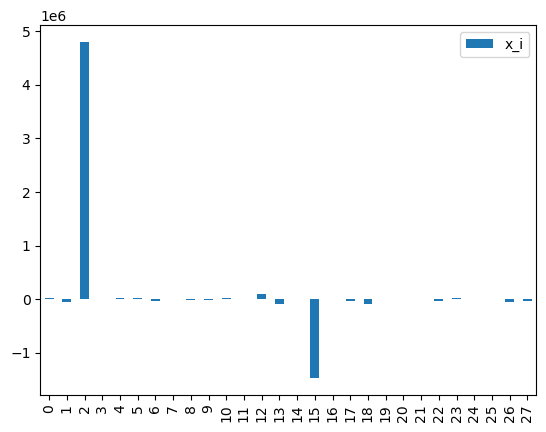

In [73]:
XX.plot.bar()

In [74]:
err = pd.DataFrame(solution[3], columns = ['e_i'])

<Axes: >

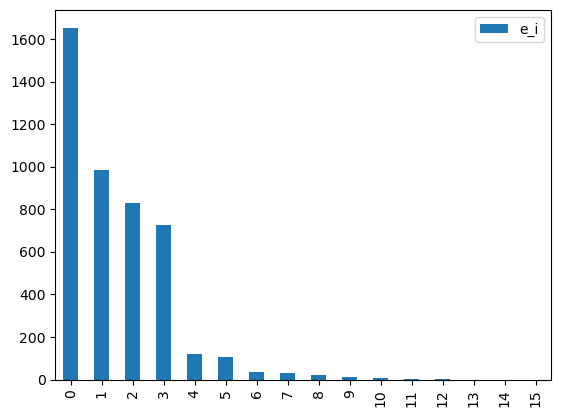

In [75]:
err.plot.bar()

In [76]:
AMBL_df_no_empty_revitid.me.unique()

array(['m³', 'm', 'Stk', 'm²'], dtype=object)

In [77]:
#AMBL_df_no_empty_revitid.loc[AMBL_df_no_empty_revitid.me == 'm²'].kurztext.unique()

### Prepare data for SLE based on only concrete

In [78]:
tmp = AMBL_df.loc[AMBL_df.me == 'm³']

In [79]:
tmp \
    .groupby('kurztext', as_index = False) \
        .agg({'ergebnis':'sum','dt':'nunique'})

,kurztext,ergebnis,dt
0,Auffüllen Beton C8/10,230.000,1
1,Az. Schwimm.Zem.E-Nutzestrich E300,2.220,1
2,Az. Schwimm.Zem.U-Nutzestrich E300,563.471,7
3,Beton Brüstung/Schürzen C25/30,8.881,1
4,"Beton D/Kragpl.b.25cm C25/30 H.3,2m",1461.868,9
5,Beton Fundamentplatte C25/30 im Gefälle,1396.608,3
6,"Beton Loggien/Balkone C25/30 H3,20m",152.760,7
7,Beton Pfahlrost,65.750,2
8,Beton Rampe,32.160,1
9,"Beton Sargdeckel C25/30 seitlich H.3,2m",13.460,11


In [80]:
#beton only
tmp = tmp.drop(
    tmp[(tmp.kurztext == 'Az. Schwimm.Zem.E-Nutzestrich E300') |
        (tmp.kurztext == 'Az. Schwimm.Zem.U-Nutzestrich E300') |
        (tmp.kurztext == 'Niveauausgleich Polystyrolbeton') |
        (tmp.kurztext == 'Schächte auffüllen mit Mineralwolle')].index)
tmp.kurztext.unique()

array(['Auffüllen Beton C8/10', 'Sauberkeitsschicht C16/20',
       'Beton Fundamentplatte C25/30 im Gefälle', 'Beton Rampe',
       'Beton Pfahlrost', 'Beton Wand C25/30 b.20cm H.3,2m',
       'Beton Wand C25/30 ü.20-40cm H.3,2m',
       'Hohlwand C25/30 ausbetonieren', 'Beton Brüstung/Schürzen C25/30',
       'Beton Stützen (Säulen oder Pfeiler) C25/30 H.3,2m',
       'Beton D/Kragpl.b.25cm C25/30 H.3,2m',
       'Beton Loggien/Balkone C25/30 H3,20m',
       'Beton Sargdeckel C25/30 seitlich H.3,2m'], dtype=object)

In [81]:
beton_per_month = tmp \
                        .groupby(['kurztext', 'dt'], as_index = False) \
                            .agg({'ergebnis':'sum'}) \
                                .sort_values(by = 'dt', ascending = True)
beton_per_month.kurztext.unique()

array(['Beton Pfahlrost', 'Sauberkeitsschicht C16/20',
       'Beton Fundamentplatte C25/30 im Gefälle', 'Auffüllen Beton C8/10',
       'Beton D/Kragpl.b.25cm C25/30 H.3,2m',
       'Hohlwand C25/30 ausbetonieren',
       'Beton Wand C25/30 ü.20-40cm H.3,2m',
       'Beton Wand C25/30 b.20cm H.3,2m',
       'Beton Stützen (Säulen oder Pfeiler) C25/30 H.3,2m', 'Beton Rampe',
       'Beton Loggien/Balkone C25/30 H3,20m',
       'Beton Sargdeckel C25/30 seitlich H.3,2m',
       'Beton Brüstung/Schürzen C25/30'], dtype=object)

In [82]:
AMBL_total_per_month = beton_per_month \
    .groupby('dt', as_index = False) \
        .agg({'ergebnis':'sum'}) \
            .rename(columns={'dt':'date', 'ergebnis':'AMBL_menge'})

In [83]:
KST_total_per_month = KST_df.loc[KST_df.konto == 30281] \
                                    .groupby('date', as_index = False) \
                                        .agg({'betrag':'sum','menge':'sum'}) \
                                            .rename(columns = {'menge':'KST_menge'})

In [84]:
AMBL_total_per_month

,date,AMBL_menge
0,2021-03-01,0.000
1,2021-04-01,932.778
2,2021-05-01,1661.479
3,2021-06-01,949.116
4,2021-07-01,263.118
5,2021-08-01,306.200
6,2021-09-01,216.620
7,2021-10-01,264.656
8,2021-11-01,280.541
9,2021-12-01,133.736


In [85]:
KST_total_per_month

,date,betrag,KST_menge
0,2021-03-01,5523.68,78.00
1,2021-04-01,43222.90,659.01
2,2021-05-01,127230.50,1807.50
3,2021-06-01,60812.14,876.50
4,2021-07-01,30571.99,449.00
5,2021-08-01,24582.12,385.00
6,2021-09-01,48721.24,756.50
7,2021-10-01,33162.64,508.00
8,2021-11-01,25378.31,379.50
9,2021-12-01,34269.72,506.50


In [86]:
merged_df = KST_total_per_month.merge(AMBL_total_per_month, how = 'outer', on = 'date')
merged_df['price'] = merged_df['betrag'] / merged_df['KST_menge']
merged_df = merged_df.sort_values(by = 'date', ascending = True)
merged_df.reset_index(drop= True , inplace= True )

### Visualize data

In [87]:
to_chart = merged_df.iloc[0:17]
to_chart = to_chart.fillna(0)
to_chart['avg'] = (to_chart['KST_menge']+to_chart['AMBL_menge'])/2
to_chart['mvg_avg'] = to_chart['KST_menge'].rolling(3).mean()
to_chart

,date,betrag,KST_menge,AMBL_menge,price,avg,mvg_avg
0,2021-03-01,5523.68,78.00,0.000,70.816410,39.0000,NaN
1,2021-04-01,43222.90,659.01,932.778,65.587624,795.8940,NaN
2,2021-05-01,127230.50,1807.50,1661.479,70.390318,1734.4895,848.170000
3,2021-06-01,60812.14,876.50,949.116,69.380650,912.8080,1114.336667
4,2021-07-01,30571.99,449.00,263.118,68.089065,356.0590,1044.333333
5,2021-08-01,24582.12,385.00,306.200,63.849662,345.6000,570.166667
6,2021-09-01,48721.24,756.50,216.620,64.403490,486.5600,530.166667
7,2021-10-01,33162.64,508.00,264.656,65.280787,386.3280,549.833333
8,2021-11-01,25378.31,379.50,280.541,66.873017,330.0205,548.000000
9,2021-12-01,34269.72,506.50,133.736,67.659862,320.1180,464.666667


<Axes: >

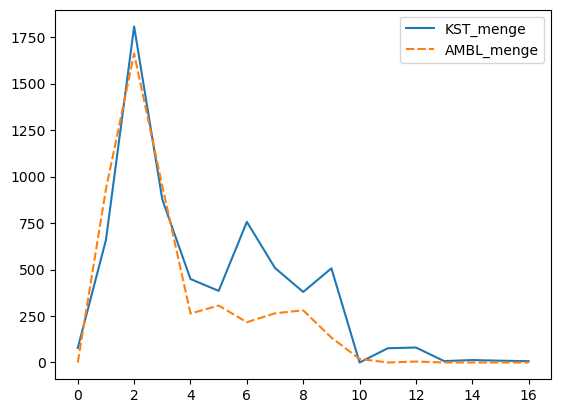

In [88]:
sns.lineplot(data = to_chart.drop(columns = ['avg','betrag', 'price','mvg_avg']))

In [89]:
merged_df['KST_menge'].sum()-merged_df['AMBL_menge'].sum()

1567.1710000000003

In [90]:
merged_df['KST_menge'].sum()

6599.51

### Solving SLE based on only data of concrete without constraints

In [91]:
### make matrix A
def create_A(df):
    month_list = df['dt'].unique()
    descr_list = df['kurztext'].unique()
    #print(month_list)
    n = len(month_list) #number of rows = number of months of the project
    m = len(descr_list) #number of columns = number of unique elemints in te project(based on kurztext)
    A = np.zeros((n, m), dtype=float)
    k = 0
    for month in month_list:
        l = 0
        for clss in descr_list:
            tmp = df.loc[(df['dt'] == month) & (df['kurztext'] == clss)]
            if tmp.shape[0]==1:
                A[k][l] = tmp.ergebnis
            l = l + 1
        k = k + 1
    return A,descr_list, month_list

In [92]:
to_b = to_chart.loc[to_chart.AMBL_menge !=0]
months = to_b.date.unique()
to_A = beton_per_month.loc[beton_per_month.dt.isin(months)]

In [93]:
AAA, list_of_names, months = create_A(to_A)
A_matrix = pd.DataFrame(AAA)


In [94]:
### convert pandas DF to numPy array
A = np.array(A_matrix, dtype = float)
b = np.array(to_b.betrag, dtype = float)

<Axes: >

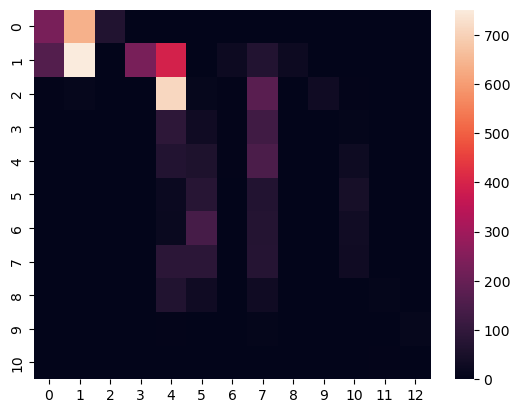

In [95]:
# visualize matrix A using heatmap
sns.heatmap(A)

In [96]:
print(A.shape)
print(b.shape)

(11, 13)
(11,)


In [97]:
solution = np.linalg.lstsq(A, b, rcond=None)
solution

(array([  3660.95081522,  -1530.30912805,   2657.65151269,  -8933.84270528,
          -265.05941713,   -162.77721369, -14340.38407184,    513.05297425,
        125590.08639445,   6737.19935405,    701.41563873,   1274.492     ,
          -302.3655931 ]),
 array([], dtype=float64),
 11,
 array([1.12930602e+03, 7.41836628e+02, 2.62890880e+02, 1.63704483e+02,
        9.34034928e+01, 2.42753561e+01, 8.87438637e+00, 8.23526425e+00,
        2.78832336e+00, 1.75837295e+00, 1.49409270e-01]))

In [98]:
list_of_names

array(['Sauberkeitsschicht C16/20',
       'Beton Fundamentplatte C25/30 im Gefälle', 'Beton Pfahlrost',
       'Auffüllen Beton C8/10', 'Beton D/Kragpl.b.25cm C25/30 H.3,2m',
       'Hohlwand C25/30 ausbetonieren',
       'Beton Wand C25/30 ü.20-40cm H.3,2m',
       'Beton Wand C25/30 b.20cm H.3,2m',
       'Beton Stützen (Säulen oder Pfeiler) C25/30 H.3,2m', 'Beton Rampe',
       'Beton Loggien/Balkone C25/30 H3,20m',
       'Beton Sargdeckel C25/30 seitlich H.3,2m',
       'Beton Brüstung/Schürzen C25/30'], dtype=object)

In [99]:
XXs = pd.DataFrame(solution[0], columns = ['x_i'],index = list_of_names)

<Axes: >

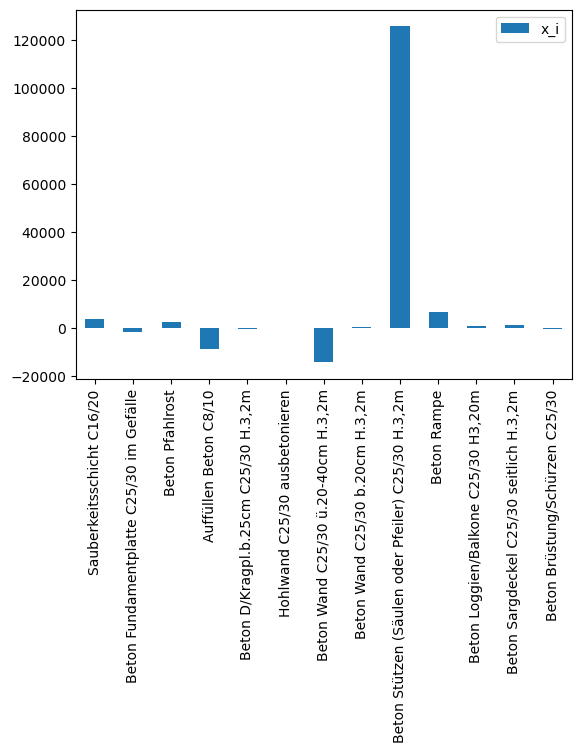

In [100]:
XXs.plot.bar()

### Write data into the file

In [101]:
A_matrix.to_csv(path_to_preprocessed + 'A_matrix_only_concrete.csv', index=False)
to_b.betrag.to_csv(path_to_preprocessed + 'b_vector_only_concrete.csv', index=False)
pd.DataFrame(months).to_csv(path_to_preprocessed + 'month_labels_only_concrete.csv', index=False)
pd.DataFrame(list_of_names).to_csv(path_to_preprocessed + 'types_labels_only_concrete.csv', index=False)

In [102]:
A_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,230.253,636.775,65.75,0.0,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.00,0.000
1,161.589,750.793,0.00,230.0,394.800,2.770,26.160,70.017,25.35,0.00,0.000,0.00,0.000
2,3.010,9.040,0.00,0.0,712.630,9.251,3.881,173.314,0.00,32.16,5.830,0.00,0.000
3,0.000,0.000,0.00,0.0,90.336,31.780,5.580,127.239,0.55,0.00,7.633,0.00,0.000
4,0.000,0.000,0.00,0.0,68.203,60.526,2.933,147.859,0.00,0.00,26.679,0.00,0.000
5,0.000,0.000,0.00,0.0,21.768,78.708,0.067,69.836,0.00,0.00,46.241,0.00,0.000
6,0.000,0.000,0.00,0.0,18.340,140.496,0.000,70.770,0.00,0.00,35.050,0.00,0.000
7,0.000,0.000,0.00,0.0,86.191,86.892,0.000,74.821,0.00,0.00,30.737,1.90,0.000
8,0.000,0.000,0.00,0.0,66.319,30.228,0.080,29.689,0.27,0.00,0.590,6.56,0.000
9,0.000,0.000,0.00,0.0,3.281,0.003,0.000,6.930,0.00,0.00,0.000,0.00,8.881
